## Empirical Benchmarking of Fully Connected vs Convolutional Architecture on MNIST

Lets empirically test the translation invariance of the two architectures. 

The training set now has a center crop transformation which crops the central pixels of the image to a given size. However, the test set has a random crop transformation which crops a random region of the image to a given size.

So we are training the neural networks with a centrally cropped image but testing it on cropped images with translations applied.

The network that has more translation invariant features should performs better on this test set.

In [1]:
import torch
from torchvision import datasets, transforms

crop_size = 22

traintransforms = []
traintransforms.append(transforms.CenterCrop(crop_size))
traintransforms.append(transforms.ToTensor())
traintransforms = transforms.Compose(traintransforms)

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=traintransforms,          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

testtransforms = []
testtransforms.append(transforms.RandomCrop(crop_size))
testtransforms.append(transforms.ToTensor())
testtransforms = transforms.Compose(testtransforms)

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=testtransforms,
                           train=False,
                          )

Train Example


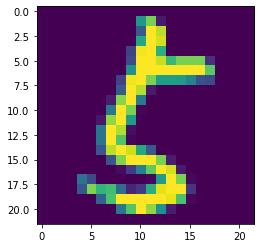

Test Example


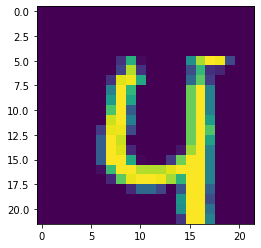

In [2]:

import matplotlib.pyplot as plt
import numpy as np
# PRINT THEIR LENGTHS AND VISUALISE AN EXAMPLE
x = train_data[np.random.randint(0, len(train_data))][0]    # get a random training example
print('Train Example')
plt.imshow(x[0].numpy())
plt.show()
x = test_data[np.random.randint(0, len(test_data))][0]    # get a random test example
print('Test Example')
plt.imshow(x[0].numpy())
plt.show()

In [3]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [4]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

We define the architectures of our fully connected and convolutional networks as well as a function which returns the number of parameters in each model. Since the number of parameters in a model is a rough measure of its capacity, the networks should have an approximately equal number of parameters to make it a fair comparison.

In [5]:
import torch.nn.functional as F 

class FullyConnectedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(crop_size*crop_size, 225),
            torch.nn.ReLU(),
            torch.nn.Linear(225, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10)
        )
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.fc_layers(x)
        x = F.softmax(x, dim=1)
        return x
    
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=1),
            torch.nn.ReLU()
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(64*(crop_size-12)*(crop_size-12), 10) # put your convolutional architecture here using torch.nn.Sequential 
            
        )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params

In [6]:
learning_rate = 0.0005 # set learning rate
epochs = 5 # set number of epochs
# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [9]:
def train(model, epochs, verbose=True, tag='Loss/Train'):
    for epoch in range(epochs):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            # pass x through your model to get a prediction
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the cost
            if verbose: print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss.item())
            optimiser.zero_grad()                  # reset the gradients attribute of all of the model's params to zero
            loss.backward()                        # backward pass to compute and store all of the model's param's gradients
            optimiser.step()                       # update the model's parameters
            
            writer.add_scalar(tag, loss, epoch*len(train_loader) + idx)    # write loss to a graph
    print('Training Complete. Final loss =',loss.item())
    

use_cuda = torch.cuda.is_available() # checks if gpu is available
device = torch.device("cuda" if use_cuda else "cpu")

cnn = ConvNet().to(device)#instantiate model
print('Number of parameters in cnn:', get_n_params(cnn))
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(cnn, epochs, verbose=False, tag='CNN Loss/Train')

Number of parameters in cnn: 128522
Training Complete. Final loss = 1.4613263607025146


In [ ]:
fnn = FullyConnectedNet().to(device)
print('Number of parameters in fnn:', get_n_params(fnn))
optimiser = torch.optim.Adam(fnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(fnn, epochs, verbose=False, tag='FNN Loss/Train')

print('CNN Train Accuracy:', calc_accuracy(cnn, train_loader))
print('CNN Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('CNN Test Accuracy:', calc_accuracy(cnn, test_loader), '\n')

print('FNN Train Accuracy:', calc_accuracy(fnn, train_loader))
print('FNN Validation Accuracy:', calc_accuracy(fnn, val_loader))
print('FNN Test Accuracy:', calc_accuracy(fnn, test_loader))

As we can see above, there is a significant disparity between the test accuracy of the two architectures, with the CNN have ~+20% test accuracy
